<a href="https://colab.research.google.com/github/Froztgal/SuperAppKit_test/blob/main/task_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor

In [28]:
def get_start_date(dataframe):

    first_date_df = dataframe.groupby(["id", "os"], as_index=False) \
        .agg({"date": "min"}).rename({"date": "first_date"}, axis=1)

    return first_date_df

In [29]:
def get_filtering_timestamp(dataframe, first_date_df, threshold_full, threshold_half):

    users_start_date = first_date_df.copy()

    users_start_date["user_date_threshold"] = \
      users_start_date.first_date + timedelta(days=threshold_full)
    
    users_start_date["user_date_threshold_train"] = \
      users_start_date.first_date + timedelta(days=threshold_half)

    users_start_date = users_start_date.drop(columns=["first_date"], axis=1)

    return users_start_date

In [30]:
def get_time_features(dataframe, first_date_df):

    time_features = first_date_df.copy()

    time_features['start_year'] = time_features['first_date'].dt.year
    time_features['start_quarter'] = time_features['first_date'].dt.quarter
    time_features['start_month'] = time_features['first_date'].dt.month
    time_features['start_week'] = time_features['first_date'].dt.isocalendar().week
    time_features['start_day'] = time_features['first_date'].dt.day
    time_features['start_day_of_week'] = time_features['first_date'].dt.weekday

    time_features = time_features.drop("first_date", axis=1)

    return time_features

In [31]:
def filter_by_time(dataframe, users_start_date):

    new_df = dataframe.copy()
    
    new_df = new_df.merge(users_start_date, on=["id", "os"], how="outer")

    train_df = new_df[new_df.date <= new_df.user_date_threshold_train]
    test_df = new_df[new_df.date <= new_df.user_date_threshold]
    
    train_df = train_df.drop(columns=["user_date_threshold"], axis=1)
    test_df = test_df.drop(columns=[ "user_date_threshold"], axis=1)

    test_df = pd.DataFrame(test_df, index = set(test_df.index). \
                           difference(set(train_df.index))).reset_index()

    train_df = train_df.drop_duplicates()
    test_df = test_df.drop_duplicates()

    train_df = train_df.groupby(["id", "os", "date"]).agg({"date": "count"}). \
      rename({"date": "counts"}, axis=1).reset_index()
    test_df = test_df.groupby(["id", "os", "date"]).agg({"date": "count"}). \
      rename({"date": "counts"}, axis=1).reset_index()

    return train_df, test_df

In [32]:
def convert_dates(dataframe, first_date_df):

    new_df = dataframe.copy()
    users_start_date = first_date_df.copy()

    new_df = new_df.merge(users_start_date, on=["id", "os"], how="left")

    new_df["date_diff"] = (new_df.date - new_df.first_date).dt.days

    new_df = new_df.drop(columns=["date", "first_date"], axis=1)

    new_df = new_df.pivot(index=["id", "os"], columns='date_diff',
                          values='counts').fillna(0).reset_index()

    for col in new_df.select_dtypes(exclude=['object']).columns:
      new_df[col] = new_df[col].astype(int)

    return new_df

In [33]:
def get_x_y_train(dataframe):

    treshold_date_full = 30
    treshold_date_train = 15

    lifetime_df = dataframe.copy()

    lifetime_df = lifetime_df[lifetime_df.date >= "2019-01-01"]

    lifetime_df.date = pd.to_datetime(lifetime_df.date)

    firts_date_df = get_start_date(lifetime_df)

    second_date_df = firts_date_df.copy()
    second_date_df.first_date = second_date_df.first_date + timedelta(days=(treshold_date_train + 1))

    start_df = get_filtering_timestamp(lifetime_df, firts_date_df, 
                                        treshold_date_full, treshold_date_train)

    train, target = filter_by_time(lifetime_df, start_df)

    converted_train = convert_dates(train, firts_date_df)
    converted_target = convert_dates(target, second_date_df)
    converted_target = converted_target.rename({0: 16, 1: 17, 2: 18, 3: 19, 
                                                4: 20, 5: 21, 6: 22, 7: 23, 
                                                8: 24, 9: 25, 10: 26, 11: 27, 
                                                12: 28, 13: 29, 14: 30}, axis=1)

    time_features = get_time_features(lifetime_df, firts_date_df)

    converted_train = converted_train.merge(time_features, on=["id", "os"], how="left")

    converted_train["sum_days"] = converted_train.iloc[:, range(2, 18)].astype(bool).sum(axis=1)

    converted_train["sum_entries"] = converted_train.iloc[:, range(2, 18)].sum(axis=1)

    converted_train["freq_days"] = converted_train.sum_days / (treshold_date_train + 1)

    whole_df = converted_train.merge(converted_target, on=["id", "os"], how="left").fillna(0)

    for col in whole_df.select_dtypes(exclude=['object']).columns:
        if col != "freq_days":
            whole_df[col] = whole_df[col].astype(int)

    whole_df.os = whole_df.os.map({'Android': 0, 'iOS': 1})
    whole_df = whole_df.rename({"os": "is_iOS"}, axis=1)

    whole_df = whole_df.drop("id", axis=1)

    X = whole_df.iloc[:, range(0, 26)]
    y = whole_df.iloc[:, range(26, 41)]
    
    return X, y

In [34]:
def get_x_y_test(dataframe):

    treshold_date_full = 30
    treshold_date_train = 15

    lifetime_df = dataframe.copy()

    lifetime_df.date = pd.to_datetime(lifetime_df.date)

    firts_date_df = get_start_date(lifetime_df)

    second_date_df = firts_date_df.copy()
    second_date_df.first_date = second_date_df.first_date + timedelta(days=(treshold_date_train + 1))

    start_df = get_filtering_timestamp(lifetime_df, firts_date_df, 
                                        treshold_date_full, treshold_date_train)

    train, target = filter_by_time(lifetime_df, start_df)

    converted_train = convert_dates(train, firts_date_df)
    converted_target = convert_dates(target, second_date_df)
    converted_target = converted_target.rename({0: 16, 1: 17, 2: 18, 3: 19, 
                                                4: 20, 5: 21, 6: 22, 7: 23, 
                                                8: 24, 9: 25, 10: 26, 11: 27, 
                                                12: 28, 13: 29, 14: 30}, axis=1)

    time_features = get_time_features(lifetime_df, firts_date_df)

    converted_train = converted_train.merge(time_features, on=["id", "os"], how="left")

    converted_train["sum_days"] = converted_train.iloc[:, range(2, 18)].astype(bool).sum(axis=1)

    converted_train["sum_entries"] = converted_train.iloc[:, range(2, 18)].sum(axis=1)

    converted_train["freq_days"] = converted_train.sum_days / (treshold_date_train + 1)

    whole_df = converted_train.merge(converted_target, on=["id", "os"], how="left").fillna(0)

    for col in whole_df.select_dtypes(exclude=['object']).columns:
        if col != "freq_days":
            whole_df[col] = whole_df[col].astype(int)

    whole_df.os = whole_df.os.map({'Android': 0, 'iOS': 1})
    whole_df = whole_df.rename({"os": "is_iOS"}, axis=1)

    whole_df = whole_df.drop("id", axis=1)

    X = whole_df.iloc[:, range(0, 26)]
    y = whole_df.iloc[:, range(26, 41)]
    
    return X, y

Connect to Google Disk to load files

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# Training

In [37]:
lifetime_df = pd.read_csv("lifetime_dataset_for_model_training.csv", sep=";")

In [38]:
X, y = get_x_y_train(lifetime_df)

In [39]:
X_new = X.copy()

In [40]:
clf = RandomForestRegressor(n_jobs=-1)

In [41]:
clf.fit(X_new, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
clf.score(X_new, y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.7242686809715988

In [43]:
yn = pd.DataFrame(clf.predict(X_new))

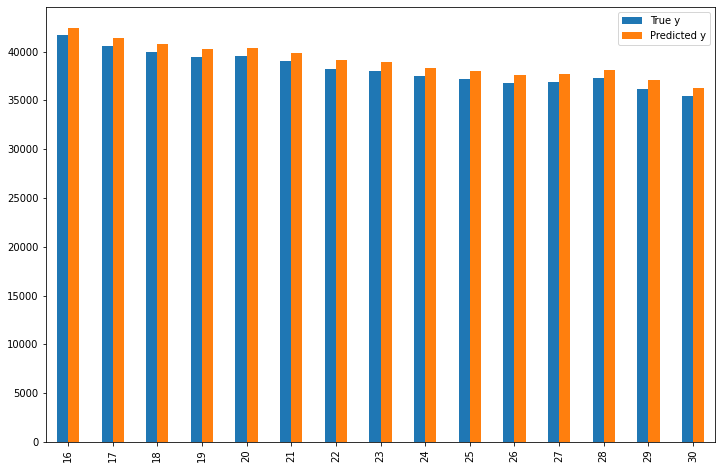

In [44]:
yplot = y.sum(axis=0)
ynplot = yn.rename({0: 16, 1: 17, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 7: 23,
                        8: 24, 9: 25, 10: 26, 11: 27, 12: 28, 13: 29, 14: 30}, 
                       axis=1).sum(axis=0)
fig = pd.DataFrame({'True y': yplot, 'Predicted y': ynplot}, index=range(16, 31)).plot.bar(figsize=(12,8))

In [45]:
result = abs(yn.rename({0: 16, 1: 17, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 7: 23,
                        8: 24, 9: 25, 10: 26, 11: 27, 12: 28, 13: 29, 14: 30}, 
                       axis=1) - y)

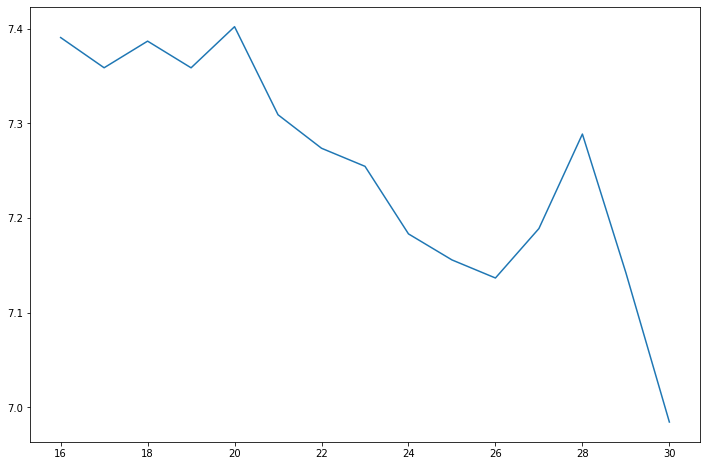

In [46]:
((result.sum(axis=0) / result.shape[0]) * 100).plot(figsize=(12,8))

# Prediction

In [47]:
lifetime_df = pd.read_csv("lifetime_dataset_for_prediction.csv", sep=";")

In [48]:
X, y = get_x_y_test(lifetime_df)

In [49]:
X_new = X.copy()

In [50]:
yn = pd.DataFrame(clf.predict(X_new))

График, на котором изображена фактическая активность пользователей и та, которую предсказывает модель

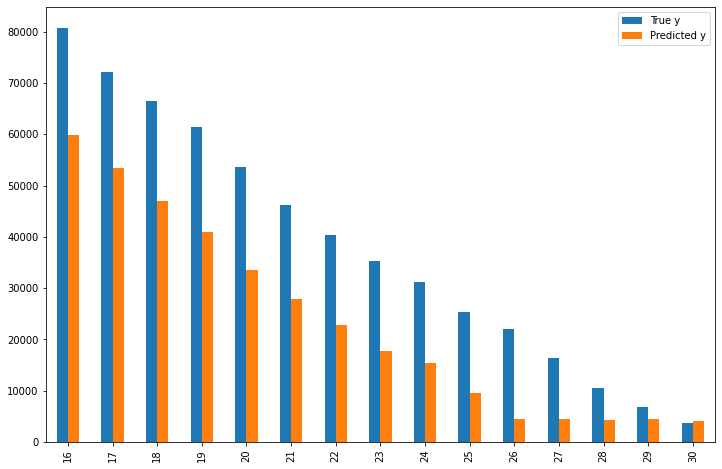

In [51]:
yplot = y.sum(axis=0)
ynplot = yn.rename({0: 16, 1: 17, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 7: 23,
                        8: 24, 9: 25, 10: 26, 11: 27, 12: 28, 13: 29, 14: 30}, 
                       axis=1).sum(axis=0)
fig = pd.DataFrame({'True y': yplot, 'Predicted y': ynplot}, index=range(16, 31)).plot.bar(figsize=(12,8))

Модель предсказывает активность пользователя на 15 дней вперед, основываясь на информации за первые пятнадцать дней. 

In [52]:
result = abs(yn.rename({0: 16, 1: 17, 2: 18, 3: 19, 4: 20, 5: 21, 6: 22, 7: 23,
                        8: 24, 9: 25, 10: 26, 11: 27, 12: 28, 13: 29, 14: 30}, 
                       axis=1) - y)

Ошибка прогноза в количестве событий по дням

In [53]:
round(result.sum(axis=0))

16    103272.0
17     94273.0
18     86016.0
19     78478.0
20     69650.0
21     60386.0
22     52256.0
23     44584.0
24     39449.0
25     31564.0
26     25837.0
27     20200.0
28     14493.0
29     10985.0
30      7651.0
dtype: float64

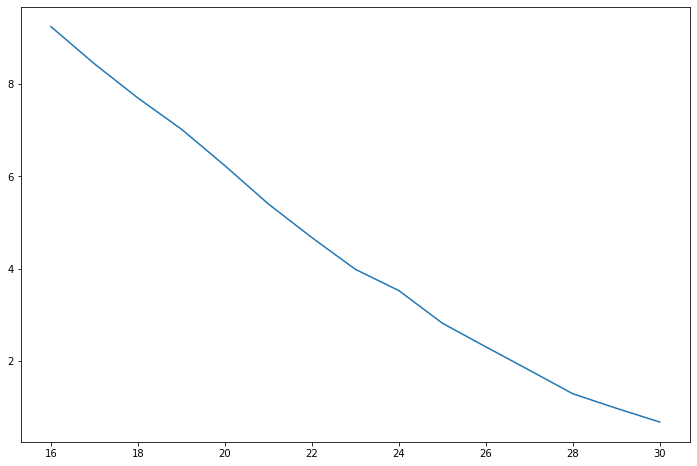

In [54]:
((result.sum(axis=0) / result.shape[0]) * 100).plot(figsize=(12,8))